# **PyTorch**

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [6]:
#Load CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the data
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:12<00:00, 13.3MB/s]


In [7]:
#Define the CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc1 = nn.Linear(128*4*4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128*4*4)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
#Define the MLP Model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(3*32*32, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 3*32*32)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
#Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

cnn_model = CNN()
mlp_model = MLP()

#Move models to the device (GPU or CPU)
cnn_model.to(device)
mlp_model.to(device)

#Define the Training and Evaluation Loop
def train_model(model, train_loader, test_loader, epochs=10, device='cpu'):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_acc = []
    test_acc = []

    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_acc.append(train_accuracy)

        # Testing the model
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracy = 100 * correct / total
        test_acc.append(test_accuracy)

        print(f'Epoch [{epoch+1}/{epochs}], Training Accuracy: {train_accuracy:.2f}%, Testing Accuracy: {test_accuracy:.2f}%')

    return train_acc, test_acc

Using device: cuda


In [11]:
def evaluate_model(model, test_loader, device='cpu'):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []  # To store the probabilities for AUC

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)  # Get probabilities
            _, predicted = torch.max(probs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())  # Store probabilities for AUC

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='weighted')  # Use probabilities for AUC

    # Calculate ROC for each class
    fpr, tpr, _ = roc_curve(all_labels, np.array(all_probs)[:, 1], pos_label=1)
    plt.plot(fpr, tpr, label='ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")

Training CNN model...
Epoch [1/10], Training Accuracy: 51.10%, Testing Accuracy: 61.11%
Epoch [2/10], Training Accuracy: 68.30%, Testing Accuracy: 69.90%
Epoch [3/10], Training Accuracy: 75.31%, Testing Accuracy: 74.43%
Epoch [4/10], Training Accuracy: 80.16%, Testing Accuracy: 75.18%
Epoch [5/10], Training Accuracy: 84.01%, Testing Accuracy: 75.80%
Epoch [6/10], Training Accuracy: 87.88%, Testing Accuracy: 74.75%
Epoch [7/10], Training Accuracy: 90.91%, Testing Accuracy: 76.33%
Epoch [8/10], Training Accuracy: 93.51%, Testing Accuracy: 76.53%
Epoch [9/10], Training Accuracy: 95.09%, Testing Accuracy: 75.73%
Epoch [10/10], Training Accuracy: 96.25%, Testing Accuracy: 75.72%


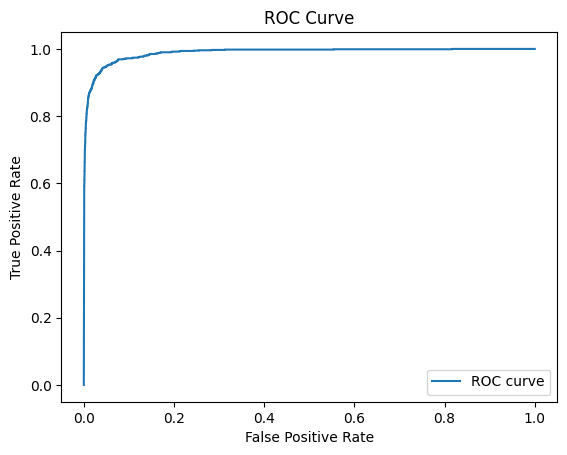

Accuracy: 0.7572
Precision: 0.7592
Recall: 0.7572
F1 Score: 0.7567
AUC: 0.9676
Training MLP model...
Epoch [1/10], Training Accuracy: 41.40%, Testing Accuracy: 46.96%
Epoch [2/10], Training Accuracy: 48.93%, Testing Accuracy: 48.82%
Epoch [3/10], Training Accuracy: 52.82%, Testing Accuracy: 50.83%
Epoch [4/10], Training Accuracy: 56.32%, Testing Accuracy: 49.88%
Epoch [5/10], Training Accuracy: 58.68%, Testing Accuracy: 52.65%
Epoch [6/10], Training Accuracy: 61.88%, Testing Accuracy: 52.27%
Epoch [7/10], Training Accuracy: 64.38%, Testing Accuracy: 53.10%
Epoch [8/10], Training Accuracy: 67.49%, Testing Accuracy: 52.59%
Epoch [9/10], Training Accuracy: 70.01%, Testing Accuracy: 53.28%
Epoch [10/10], Training Accuracy: 72.05%, Testing Accuracy: 52.65%


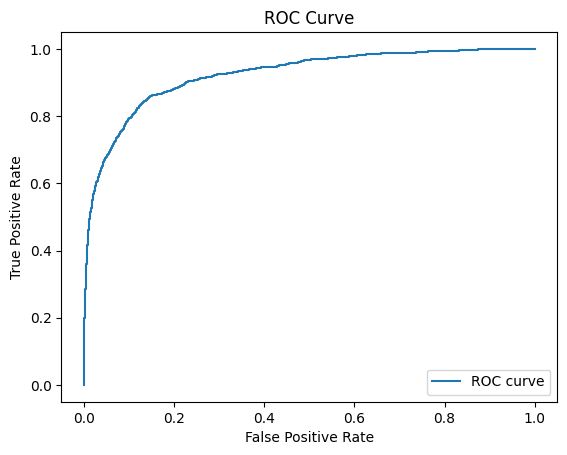

Accuracy: 0.5265
Precision: 0.5305
Recall: 0.5265
F1 Score: 0.5272
AUC: 0.8854


In [14]:
#Train and Evaluate CNN
cnn_model = CNN()
print("Training CNN model...")
cnn_train_acc, cnn_test_acc = train_model(cnn_model, train_loader, test_loader, epochs=10, device=device)
evaluate_model(cnn_model, test_loader, device=device)

#Train and Evaluate MLP
mlp_model = MLP()
print("Training MLP model...")
mlp_train_acc, mlp_test_acc = train_model(mlp_model, train_loader, test_loader, epochs=10, device=device)
evaluate_model(mlp_model, test_loader, device=device)

# **TensorFlow**

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

In [16]:
# 1. Load CIFAR-10 Dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Convert labels to categorical (one-hot encoding)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# 2. Define the CNN Model (using TensorFlow/Keras)
def create_cnn_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(10, activation='softmax')  # Output layer for multi-class classification
    ])
    return model

# 3. Define the MLP Model (using TensorFlow/Keras)
def create_mlp_model():
    model = models.Sequential([
        layers.Flatten(input_shape=(32, 32, 3)),
        layers.Dense(1024, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(10, activation='softmax')  # Output layer for multi-class classification
    ])
    return model

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [17]:
# 4. Compile and Train the Model
def train_model(model, x_train, y_train, x_test, y_test, epochs=10):
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(x_train, y_train, epochs=epochs, batch_size=64, validation_data=(x_test, y_test))

    # Evaluate the model
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print(f'Test accuracy: {test_acc:.4f}')

    return model

In [18]:
# 5. Evaluate with Metrics: Accuracy, Precision, Recall, F1, AUC, and ROC
def evaluate_model(model, x_test, y_test):
    # Predict the classes
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    auc = roc_auc_score(y_test, y_pred, multi_class='ovr', average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")

    # Calculate ROC curve for each class
    fpr, tpr, _ = roc_curve(y_test_classes, y_pred[:, 1], pos_label=1)  # Class 1 for example
    plt.plot(fpr, tpr, label='ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training CNN model...
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.3956 - loss: 1.6463 - val_accuracy: 0.6073 - val_loss: 1.0842
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6534 - loss: 0.9877 - val_accuracy: 0.6930 - val_loss: 0.8783
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7237 - loss: 0.7880 - val_accuracy: 0.7121 - val_loss: 0.8374
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7725 - loss: 0.6481 - val_accuracy: 0.7307 - val_loss: 0.7895
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8146 - loss: 0.5286 - val_accuracy: 0.7343 - val_loss: 0.7755
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8484 - loss: 0.4331 - val_accuracy: 0.7539 - val_loss: 0.7866
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8846 - loss: 0.3290 - val_accuracy: 0.7534 - val_loss: 0.7966
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9137 - loss: 0.

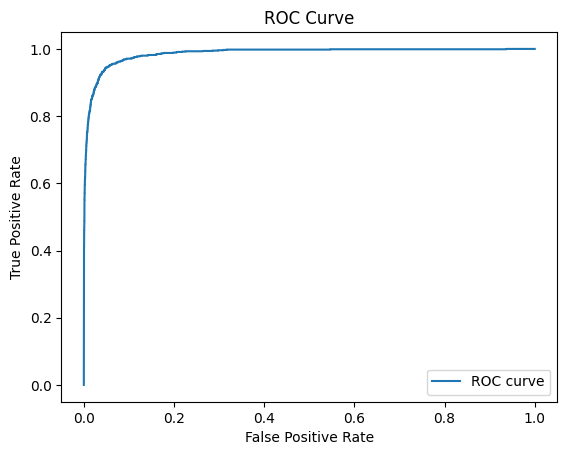

Training MLP model...
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.2756 - loss: 2.1001 - val_accuracy: 0.3669 - val_loss: 1.8097
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.3956 - loss: 1.6897 - val_accuracy: 0.4080 - val_loss: 1.6365
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4350 - loss: 1.5813 - val_accuracy: 0.4510 - val_loss: 1.5575
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4609 - loss: 1.5101 - val_accuracy: 0.4476 - val_loss: 1.5563
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4739 - loss: 1.4702 - val_accuracy: 0.4743 - val_loss: 1.4882
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4902 - loss: 1.4306 - val_accuracy: 0.4808 - val_loss: 1.4626
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4985 - loss: 1.3958 - val_accuracy: 0.4923 - val_loss: 1.4325
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5092 - loss: 1.3

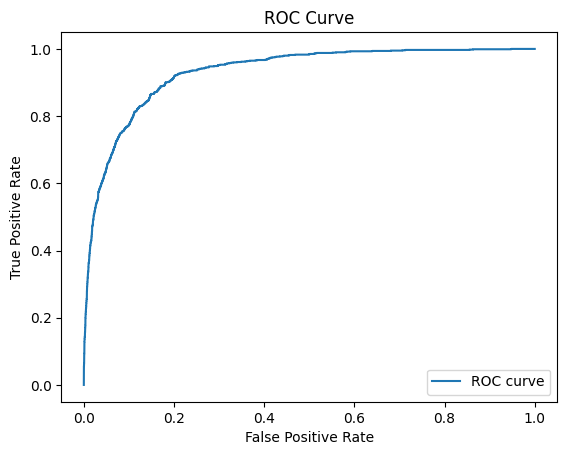

In [19]:
# 6. Initialize Models
cnn_model = create_cnn_model()
mlp_model = create_mlp_model()

# 7. Train and Evaluate CNN Model
print("Training CNN model...")
cnn_model = train_model(cnn_model, x_train, y_train, x_test, y_test, epochs=10)
evaluate_model(cnn_model, x_test, y_test)

# 8. Train and Evaluate MLP Model
print("Training MLP model...")
mlp_model = train_model(mlp_model, x_train, y_train, x_test, y_test, epochs=10)
evaluate_model(mlp_model, x_test, y_test)